For me, there was a lot of controversy about when to split dataset into train and test sets. On the one hand, if we will split the data at the beggining, we can avoid any information leakage and we can validate our model on data, that our model have never seen before (which i basically the goal of splitting data this way). From the other hand, getting rid of, for example 20% of our data will decrease our overall knowledge about the data. This is important becasue we are using this knowlegde in order to proceede through EDA (exploratory data analysis) with highest possible effiency this is - filling the missing values, doing feature engeeniring all in the best possible way and to do so it's obviously better to have more data. 

In order to avoid any mistakes I will try to follow rules listed below:
1. try not to include any information from train into test set and vice versa 
2. try to do exploratory analysis before doing splitting
3. fill missing values / normalize or scale the data after splitting
4. include cross-validation before validating model on test set

About the structure: I will try to fit as many transformers to the sklearn's pipeline as i can. This will speed up the whole process of cleaning and working with data. For those purpose I'm going to write my own classes to adress my specific requierments.

General approach, steps:
1. Importing libraries and data
2. Data exploration, plotting, correlation
3. spliting data into train and test set
4. Feature engineering
5. Feature selection
6. Cross-validation on train set
7. Go back to step 4. and proceed, if necessary
8. Preprocessing the test set and validating model based on that data

steps 3rd and 4th can be mixed togother sometimes. It really depend on situation.

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                      

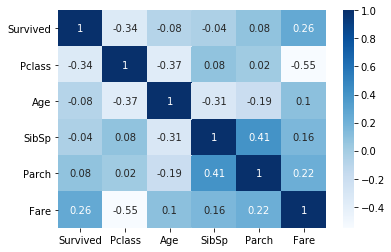

In [176]:
def load_and_present(file_name, head=True, na=True, info=True):
    #file_name - name of the file (.csv)
    #head - whether to show the first 5 rows
    #na - whether to show if there are any miising values in dataset
    #info - whether to show basic inforamtions about data(frame)

    raw_data = pd.read_csv(file_name)
    if info:
        print(raw_data.info())
    if head:
        print(raw_data.head())
    if na:
        print("MIssing values:\n",raw_data.isna().sum())
    return raw_data


data = load_and_present("train.csv")
submission_data =  load_and_present("test.csv", head=False, info=False)


LEN = len(data)
COLUMNS_TO_DROP = []


pass_id = submission_data["PassengerId"]#will be used later
data.drop(["PassengerId", "Name","Ticket","Cabin"],axis=1,inplace=True)
submission_data.drop(["PassengerId", "Name","Ticket","Cabin"],axis=1,inplace=True)


#missing value easiest treatment
data["Embarked"].fillna(inplace=True,value="Q")
submission_data["Fare"].fillna(inplace=True,value=submission_data["Fare"].mean())

sns.heatmap(round(data.corr(),2),annot=True,cmap='Blues')
plt.show()

3    491
1    216
2    184
Name: Pclass, dtype: int64


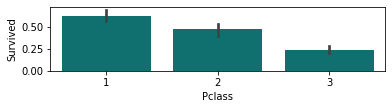

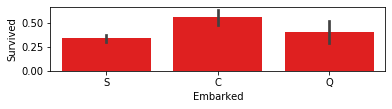

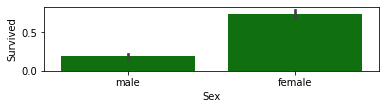

In [177]:
#some plots
plt.subplot(311)
sns.barplot("Pclass", "Survived", data=data, color="teal")
print(data["Pclass"].value_counts())
plt.show()
plt.subplot(312)
sns.barplot("Embarked", "Survived", data=data, color="red")
plt.show()
plt.subplot(313)
sns.barplot("Sex", "Survived",data=data, color="green")
plt.show()

In [178]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression


#class for getting dummy variables 
class getting_dummies_01():
    def __init__(self,variables_to_dummies):
        self.variables = variables_to_dummies
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        output = pd.DataFrame()
        for column in self.variables:
            encoded = pd.get_dummies(X[column],drop_first=True)
            output = pd.concat([output,encoded],axis=1)     
        return pd.concat([output, X.drop(self.variables,axis=1)],axis=1)

    
    
class filling_values_regression_method():
    def __init__(self,variable_to_fill):
        self.variable = variable_to_fill
    def fit(self, X,y=None):
        return self
    def transform(self, X, y=None):
        train = X.dropna()
        test = X[X[self.variable].isnull()].drop([self.variable],axis=1)
        lm = LinearRegression().fit(train.drop([self.variable],axis=1),train[self.variable])    
        return X[self.variable].fillna(value=pd.Series(lm.predict(test)),inplace=True)

In [179]:


#funkcja tworzaca zmienne typu "dummies"
def getting_dummies(data,cat_variables):
    output = pd.DataFrame()
    for column in cat_variables:
        encoded = pd.get_dummies(data[column],drop_first=True)
        output = pd.concat([output,encoded],axis=1)     
    return pd.concat([output, data.drop(cat_variables,axis=1)],axis=1)

#function to make inside regression in order to  fill missing values in more robust way
def filling_values_regression(data, variable_to_fill):
    train = sm.add_constant(data.dropna())
    test = sm.add_constant(data[data[variable_to_fill].isnull()].drop([variable_to_fill],axis=1))
    lm = OLS(train[variable_to_fill],train.drop([variable_to_fill],axis=1)).fit()
    data[variable_to_fill].fillna(value=lm.predict(test),inplace=True)
    return data


In [180]:
#Using pipeline
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[
    ("dummies", getting_dummies_01(variables_to_dummies=["Embarked", "Pclass","Sex"])),
    ("filling_age", filling_values_regression_method(variable_to_fill="Age"))
])
t = pipeline.fit_transform(submission_data)

In [181]:
t

In [182]:
data = getting_dummies(data=data, cat_variables=["Sex", "Pclass", "Embarked"])
submission_data = getting_dummies(data=submission_data, cat_variables=["Sex", "Pclass", "Embarked"])
filling_values_regression(data,"Age")
filling_values_regression(submission_data,"Age")

male  2  3  Q  S        Age  SibSp  Parch      Fare
0       1  0  1  1  0  34.500000      0      0    7.8292
1       0  0  1  0  1  47.000000      1      0    7.0000
2       1  1  0  1  0  62.000000      0      0    9.6875
3       1  0  1  0  1  27.000000      0      0    8.6625
4       0  0  1  0  1  22.000000      1      1   12.2875
..    ... .. .. .. ..        ...    ...    ...       ...
413     1  0  1  0  1  25.402974      0      0    8.0500
414     0  0  0  0  0  39.000000      0      0  108.9000
415     1  0  1  0  1  38.500000      0      0    7.2500
416     1  0  1  0  1  25.402974      0      0    8.0500
417     1  0  1  0  0  21.895796      1      1   22.3583

[418 rows x 9 columns]

# Feature extraction


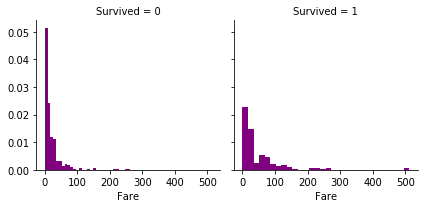

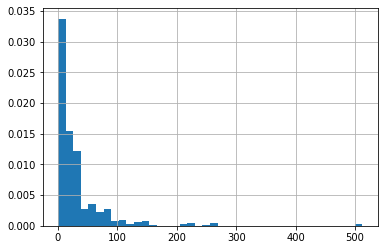

In [183]:
g = sns.FacetGrid(data, col="Survived")
g.map(plt.hist,"Fare",color="purple",bins=30,density=True)
plt.show()
data["Fare"].hist(bins=40,density=True)
plt.show()
qt_25 = data["Fare"].describe()[4]#0.25 quantile
data["low_fare"] = (data["Fare"]<30).astype(int)
submission_data["low_fare"] = (submission_data["Fare"]<50).astype(int)
COLUMNS_TO_DROP.append("Fare")

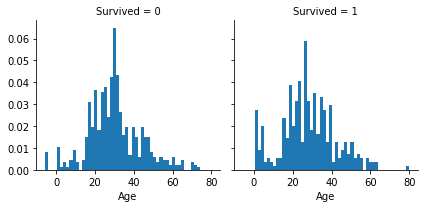

In [184]:
g = sns.FacetGrid(data, col='Survived')
g.map(plt.hist, 'Age', bins=50,density=True)
plt.show()

data["baby"] = (data["Age"]<6).astype(int)
submission_data["baby"] = (submission_data["Age"]<6).astype(int)

data["old"] = (data["Age"]>40).astype(int)
submission_data["old"] = (submission_data["Age"]>40).astype(int)

COLUMNS_TO_DROP.append("Age")

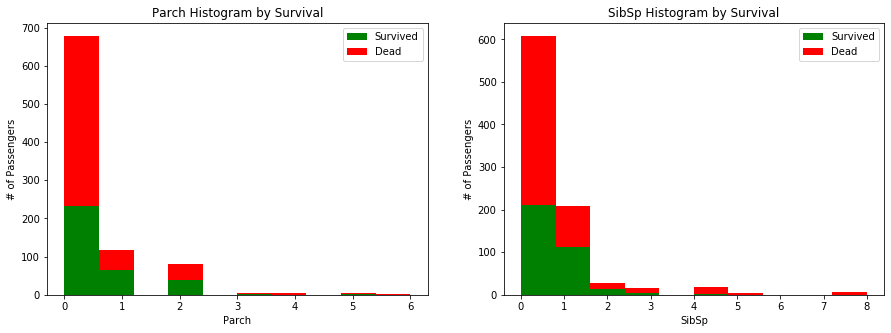

In [185]:
plt.figure(figsize=[15,5])
plt.subplot(121)
plt.hist(x = [data[data["Survived"]==1]["Parch"], data[data["Survived"]==0]["Parch"]], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title("Parch Histogram by Survival")
plt.xlabel("Parch")
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(122)
plt.hist(x = [data[data["Survived"]==1]["SibSp"], data[data["Survived"]==0]["SibSp"]], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title("SibSp Histogram by Survival")
plt.xlabel("SibSp")
plt.ylabel('# of Passengers')
plt.legend()
plt.show()

#data["Parch_is_alone"] = (data["Parch"] == 0).astype(int)
#data["SibSp_is_alone"] = (data["SibSp"] == 0).astype(int)
#submission_data["Parch_is_alone"] = (submission_data["Parch"] == 0).astype(int)
#submission_data["SibSp_is_alone"] = (submission_data["SibSp"] == 0).astype(int)
#COLUMNS_TO_DROP.append("Parch")
#COLUMNS_TO_DROP.append("SibSp")

In [186]:
#Preparing training and test set

data.drop(COLUMNS_TO_DROP,axis=1,inplace=True)


train = data.iloc[:int(LEN*0.8),]
test = data.iloc[int(LEN*0.8):,]
print("Zbior treningowy:", train.Survived.sum()/len(train), "\n","Zbior treningowy:", test.Survived.sum()/len(test))

#k-fold cross validation
from sklearn.model_selection import StratifiedKFold
from statsmodels.discrete.discrete_model import Logit
def My_own_kfold_cross_validation(model,metrics,Predictors,labels,random_state,n_splits=5,shuffle=False):
    stratifiedkfold = StratifiedKFold(n_splits=n_splits,random_state=random_state,shuffle=shuffle)
    mean_score = 0 
    for train_index, test_index in stratifiedkfold.split(X=np.zeros(len(labels)), y=labels):
        #print("TRAIN:", train_index, "\n","TEST:", test_index)
        X_train, X_test = Predictors[train_index], Predictors[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        score = metrics(model(y_train,sm.add_constant(X_train)).fit(),data_matrix=X_test,labels=y_test)
        #print("score:",score)
        mean_score+=score
    return mean_score/n_splits
        

y = data["Survived"].to_numpy()
X = data.drop(["Survived"],axis=1).to_numpy()
My_own_kfold_cross_validation(model=Logit,metrics=score,Predictors=X,labels=y,random_state=14,n_splits=10,shuffle=True)

Zbior treningowy: 0.3904494382022472 
 Zbior treningowy: 0.3575418994413408
Optimization terminated successfully.
         Current function value: 0.429437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419469
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413316
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.416641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420594
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430546
         Iterations 6
Optimi

0.8215106117353308

In [187]:
from sklearn.linear_model import LogisticRegression
from statsmodels.discrete.discrete_model import Logit



y_train = train["Survived"]
x_train = train.drop(["Survived"],axis=1)
y_test = test["Survived"]
x_test = test.drop(["Survived"],axis=1)




In [188]:
from statsmodels.api import OLS
model = Logit(y_train,sm.add_constant(x_train)).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.438118
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      701
Method:                           MLE   Df Model:                           10
Date:                Thu, 16 Apr 2020   Pseudo R-squ.:                  0.3451
Time:                        22:22:52   Log-Likelihood:                -311.94
converged:                       True   LL-Null:                       -476.29
Covariance Type:            nonrobust   LLR p-value:                 1.308e-64
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4453      0.375      9.179      0.000       2.710       4.181
male          -2.7500      0.

In [189]:
#model = LogisticRegression(max_iter=1000).fit(x_train,y_train)
def score(model, data_matrix, labels):
    predictions = [1 if (i > 0.5) else 0 for i in model.predict(sm.add_constant(data_matrix))]
    score = sum((predictions == labels)) /len(labels)
    return score

#score(model,x_test,y_test)

# Adjusting the model

In [190]:
model = Logit(y_train,sm.add_constant(x_train.drop(["Q"],axis=1))).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.438138
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      702
Method:                           MLE   Df Model:                            9
Date:                Thu, 16 Apr 2020   Pseudo R-squ.:                  0.3450
Time:                        22:22:53   Log-Likelihood:                -311.95
converged:                       True   LL-Null:                       -476.29
Covariance Type:            nonrobust   LLR p-value:                 2.127e-65
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4638      0.359      9.643      0.000       2.760       4.168
male          -2.7549      0.

In [191]:
model = Logit(y_train,sm.add_constant(x_train.drop(["Q",2],axis=1))).fit()
print(model.summary())
#print(x_train.columns)
print(score(model,x_test.drop(["Q",2],axis=1),y_test))
COLUMNS_TO_DROP.append("Q")
COLUMNS_TO_DROP.append(2)

Optimization terminated successfully.
         Current function value: 0.440570
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      703
Method:                           MLE   Df Model:                            8
Date:                Thu, 16 Apr 2020   Pseudo R-squ.:                  0.3414
Time:                        22:22:53   Log-Likelihood:                -313.69
converged:                       True   LL-Null:                       -476.29
Covariance Type:            nonrobust   LLR p-value:                 1.756e-65
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3382      0.348      9.606      0.000       2.657       4.019
male          -2.7323      0.

In [192]:
all_data = pd.concat([x_train,x_test],axis=0)
all_y = pd.concat([y_train,y_test],axis=0)
model = Logit(all_y,sm.add_constant(all_data.drop(["Q",2],axis=1))).fit()
print(model.summary())
submission_data.dropna(inplace=True)
submission_data.drop(COLUMNS_TO_DROP, axis=1, inplace=True)
print(submission_data.head())
final_submission = pd.DataFrame(data={"PassengerId":pass_id,
    "Survived":[1 if (i > 0.5) else 0 for i in model.predict(sm.add_constant(submission_data.to_numpy()).reshape(418,-1))]
        })
print(final_submission.head())
final_submission.to_csv(path_or_buf="submission_04.csv",index=False)



Optimization terminated successfully.
         Current function value: 0.428362
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      882
Method:                           MLE   Df Model:                            8
Date:                Thu, 16 Apr 2020   Pseudo R-squ.:                  0.3567
Time:                        22:22:53   Log-Likelihood:                -381.67
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 1.920e-86
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4675      0.321     10.802      0.000       2.838       4.097
male          -2.8427      0.